In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils as pic
    
%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-5    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 4000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0099   # Time steps

In [4]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [5]:
X_e_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )
y_b_train = to_categorical(y_train)

In [6]:
X_e_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep )
y_b_valid = to_categorical(y_valid)


In [7]:
X_e_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=True, min_t=tmin, max_t=tmax, t_step=tstep)
y_b_test = to_categorical(y_test)


In [8]:
model = keras.Sequential()

model.add(layers.Reshape((maxframes, 32, 32, 1),input_shape=(maxframes, 32, 32)))
model.add(layers.Conv3D(32, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool3D())
model.add(layers.Conv3D(16,3,activation='relu',padding='same'))
model.add(layers.MaxPool3D())
model.add(layers.Flatten())
model.add(layers.Dense(25,activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 32, 32, 1)     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 21, 32, 32, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 32, 32, 32)    128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 16, 16, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 16, 16, 16)    13840     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 8, 8, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0

In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(
    learning_rate=lr_init), metrics=['accuracy'])


In [10]:
history = model.fit(
    X_e_train, y_b_train,
    validation_data=(X_e_valid, y_b_valid),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)


Epoch 1/20
80/80 [==============================] - 321s 4s/step - loss: 0.6941 - accuracy: 0.4967 - val_loss: 0.6930 - val_accuracy: 0.5015
Epoch 2/20
80/80 [==============================] - 319s 4s/step - loss: 0.6891 - accuracy: 0.5119 - val_loss: 0.6927 - val_accuracy: 0.5865
Epoch 3/20
80/80 [==============================] - 319s 4s/step - loss: 0.6859 - accuracy: 0.5436 - val_loss: 0.6919 - val_accuracy: 0.5955
Epoch 4/20
44/80 [===============>..............] - ETA: 2:21 - loss: 0.6839 - accuracy: 0.5623

KeyboardInterrupt: 

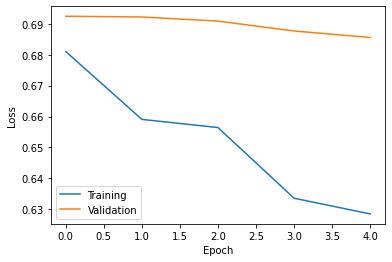

In [ ]:
pic.plot_history(history)

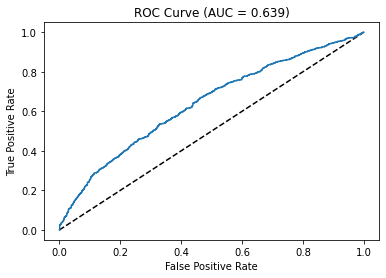

In [11]:
%matplotlib inline
pic.plot_roc(y_b_test[:,0], model.predict(X_e_test)[:,0])